In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io

url_x = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy'
url_y = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [3]:
def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return vec + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=vec.shape)

In [4]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [5]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


# Clipping and Gradient definition

In [6]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [7]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    clipped_grads = L2_clip_array(gradients, C)
    return np.sum(clipped_grads, axis = 0)

In [8]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

In [9]:
def dp_gradient_descent(iterations, alpha, epsilon):
    eps_i = epsilon/iterations
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 5
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy
    for i in range(iterations):
        grad_sum        = vgradient(theta, X_train, y_train, clipping_param)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, clipping_param, 1, 1e-5)
        noisy_avg_grad  = noisy_grad_sum / num_examples
        theta           = theta - noisy_avg_grad

    return theta

# Baseline (gradient clipping DP-SGD)

In [10]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [11]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grad_sum        = vgradient(theta, xs, ys, clipping_param)
            noisy_grad_sum  = gaussian_mech_zCDP_vec(grad_sum, clipping_param, rho_i)
            noisy_avg_grad  = noisy_grad_sum / BATCH_SIZE
            theta           = theta - noisy_avg_grad

    return theta

In [12]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [13]:
get_eps(.01, 500, 1e-5)

Total epsilon = 0.033071994919780016, delta = 1e-05


0.033071994919780016

In [14]:
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho * np.log(1/delta))
zcdp_eps(0.001, 1e-5)

0.21559660262893474

In [15]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7616099071207432
std: 0.020437492776487078


# Smooth Sensitivity Trimmed Mean

In [20]:
def get_with_default(values, indexes, lower, upper):
    return np.concatenate(([lower], values, [upper]))[
        np.maximum(np.minimum(indexes, len(values)), -1) + 1]

In [21]:
def build_indices(n, m, k_range):
    lhs_indices = []
    rhs_indices = []
    for k in range(0, k_range):
        lhs_indices.append(np.array([n-m+1+k-l for l in range(0, k+2)]))
        rhs_indices.append(np.array([m+1-l for l in range(0, k+2)]))
    return (lhs_indices, rhs_indices)

In [22]:
n = 20
m = 2
a = 0
b = 10
lhs_indices, rhs_indices = build_indices(n, m, 128)

In [261]:
def compute_sens(xs, t, n, m, a, b, lhs_indices, rhs_indices):
    sorted_xs = np.sort(xs)

    # calculate the smooth sensitivity
    scaled_sensitivity_at_distances = []

    #for k in range(0, n+1):
    for k in range(0, 5): # TODO: loop over k (but this is slow)
        scaling = np.exp(- k * t)
        
        lhs = get_with_default(sorted_xs, lhs_indices[k], a, b)
        rhs = get_with_default(sorted_xs, rhs_indices[k], a, b)
        inner = np.abs(lhs - rhs)
        #print('new inner:', new_inner)
        #print('indices:', lhs_indices)
        #inner = np.array([abs(get(n-m+1+k-l) - get(m+1-l)) for l in range(0, k+2)])
        #print('inner:', inner)
        inner_max = np.max(inner)
        scaled_inner = scaling * inner_max
        #print('k:', k, 'scaled sens:', scaled_inner)
        scaled_sensitivity_at_distances.append(scaled_inner)

    return (1/(n - 2*m)) * np.max(np.array(scaled_sensitivity_at_distances))

In [220]:
t = .01
test_array = np.random.normal(loc=5, scale=1, size=20).clip(a, b)
compute_sens(test_array, t, n, m, a, b, lhs_indices, rhs_indices)

k: 0 scaled sens: 5.032321360958584
k: 1 scaled sens: 5.154668972553409
k: 2 scaled sens: 5.185738893933184
k: 3 scaled sens: 5.244825861386485
k: 4 scaled sens: 5.481916618896184
k: 5 scaled sens: 5.52989667461204
k: 6 scaled sens: 5.747324250336256
k: 7 scaled sens: 5.877494314247135
k: 8 scaled sens: 5.984494477157072
k: 9 scaled sens: 6.18701739643547
k: 10 scaled sens: 6.77302062428658
k: 11 scaled sens: 8.958341352965283
k: 12 scaled sens: 8.869204367171575
k: 13 scaled sens: 8.780954309205613
k: 14 scaled sens: 8.69358235398806
k: 15 scaled sens: 8.607079764250578
k: 16 scaled sens: 8.521437889662113
k: 17 scaled sens: 8.436648165963836
k: 18 scaled sens: 8.35270211411272
k: 19 scaled sens: 8.269591339433623
k: 20 scaled sens: 8.187307530779819
k: 21 scaled sens: 8.10584245970187
k: 22 scaled sens: 8.025187979624786
k: 23 scaled sens: 7.94533602503334
k: 24 scaled sens: 7.8662786106655345
k: 25 scaled sens: 7.788007830714049
k: 26 scaled sens: 7.710515858035663
k: 27 scaled sens

0.10664692086863431

In [216]:
a = 0
b = 10
t = 5

m = 10
n = 104
lhs_indices, rhs_indices = build_indices(n, m, 100)

def test_sens(t):
    test_array = np.random.normal(loc=5, scale=1, size=104).clip(a, b)
    n = len(test_array)
    #lhs_indices, rhs_indices = build_indices(n, m, 3)
    return compute_sens(test_array, t, n, m, a, b, lhs_indices, rhs_indices)

In [191]:
10/104

0.09615384615384616

In [196]:
%%time
ts = np.linspace(0.0001, 0.1, 100)
results = [np.mean([test_sens(t) for _ in range(50)]) for t in ts]

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.3 s


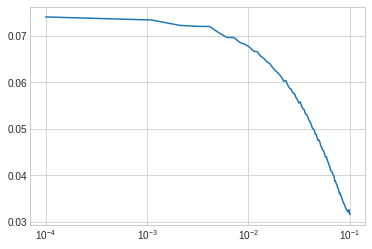

In [197]:
plt.plot(ts,results)
plt.xscale('log');

# Smooth Sensitivity DP-SGD

In [315]:
def vgradient_per_ex(theta_in, x_in, y_in):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients

def smooth_dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    upper = 1
    lower = -1
    m = 100
    #t = 80

    #alpha = 100
    t = .01
    
    BATCH_SIZE = 256
    lhs_indices, rhs_indices = build_indices(BATCH_SIZE, m, BATCH_SIZE)
    
    rho_weight = rho_i / X_train.shape[1]
    print('target per-weight rho:', rho_weight)
    target_eps_weight = np.sqrt(2*rho)
    sigma = opt_sigma(target_eps_weight, t)
    #sigma = 1
    s = np.exp(-(3/2) * sigma**2) * (target_eps_weight - (t / sigma))
    print('sigma:', sigma, 's:', s)
    #1/0

    #assert 1/(1-np.exp(-t)) > alpha
    #gamma = alpha*(np.exp(t) - 1) + 1
    #print('gamma:', gamma)
    #epsilon = rho
    #epsilon_epoch = epsilon / epochs
    #epsilon_iter = epsilon_epoch / X_train.shape[1]
    #print('epsilon per weight:', epsilon_iter)

    def compute_eps(sens, alpha, t, sigma_sq):
        alpha_upper_bound = 1/(1-np.exp(-t))
        if alpha >= alpha_upper_bound:
            raise RuntimeError('alpha too high!!! t:', t, 'alpha:', alpha, 'req alpha <', 1/(1-np.exp(-t)))
        gamma = 1 - alpha*(1-np.exp(-t))
        return alpha * ((sens**2 / (2*gamma*sigma_sq)) + (t**2 / (4*gamma**2)))

    def compute_sigma_sq(sens):
        gamma = 1 - alpha*(1-np.exp(-t))
        #print('gamma:', gamma)

        top = (alpha * (sens**2))
        bottom_lhs = (2 * gamma * epsilon_iter)
        bottom_rhs = ((alpha * t**2) / (2 * gamma))
        #print('bottom lhs:', bottom_lhs)
        #print('bottom rhs:', bottom_rhs)
        return (top / (bottom_lhs - bottom_rhs))

    def spec_trimmed_mean(xs):
        return trimmed_mean(xs, t, m, lower, upper, lhs_indices, rhs_indices, compute_sigma_sq, sigma, s)
    
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)
    
    #spec_trimmed_mean = lambda xs: trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, sigma, s)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            gradients       = vgradient_per_ex(theta, xs, ys)
            noisy_avg_grad  = np.apply_along_axis(spec_trimmed_mean, 0, gradients)
            theta           = theta - noisy_avg_grad

    return theta

In [316]:
def opt_exp(eps, t, sigma):
    return 5 * (eps / t) * sigma**3 - 5 * sigma**2 - 1

def opt_sigma(target_eps, t):
    sigma_lower = t / target_eps
    sigma_upper = max(2*t / target_eps, 1/2)
    
    loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))
    while np.abs(loss) > 0.001:
        #print('loss:', loss)
        if loss < 0:
            sigma_lower = np.mean([sigma_lower, sigma_upper])
        else:
            sigma_upper = np.mean([sigma_lower, sigma_upper])

        loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))

    return np.mean([sigma_lower, sigma_upper])

def trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, compute_sigma_sq, lln_sigma, s):
    clipped_xs = xs.clip(a, b)
    n = len(clipped_xs)
    #print('actual mean', np.mean(xs))
    sens = compute_sens(clipped_xs, t, n, m, a, b, lhs_indices, rhs_indices)
    noise = one_lln(lln_sigma)
    #print('scaling:', sens/s)
    return np.mean(clipped_xs) + (sens/s)*noise
    #print('sens:', sens)
    #sigma_sq = compute_sigma_sq(sens)
    #print('sigma_sq:', sigma_sq)
    #print(sigma_sq)
    # return np.mean(xs) + np.random.normal(loc=0, scale=np.sqrt(sigma_sq))
    
    #rho = (t**2/sigma**2) + (np.exp(3*sigma**2)*s**2)
    #print('actual rho:', rho)
    #print('noise scale:', (sens / s))
    return np.mean(xs)

In [322]:
accuracy(smooth_dp_gradient_descent(1, .001))

target per-weight rho: 9.615384615384616e-06
sigma: 0.44723157125011803 s: 0.016565465293381355


0.8239716939407342

In [74]:
zcdp_eps(0.001, 1e-5)

0.21559660262893474

# Ours Experiments

In [375]:
our_means = means[3:]
our_stds = stds[3:]

In [132]:
rhos = [0.01, 0.001, 0.0001]
our_epsilons = [zcdp_eps(rho, 1e-5) for rho in rhos]

our_means = []
our_stds = []
for rho in rhos:
    accs = [accuracy(smooth_dp_gradient_descent(5, rho)) for _ in range(10)]
    our_means.append(np.mean(accs))
    our_stds.append(np.std(accs))    

target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-05
sigma: 0.05233077384128604 s: 0.13893853411612533
target per-weight rho: 1.923076923076923e-06
sigma

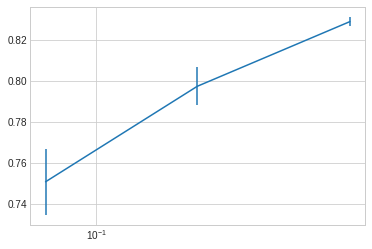

In [133]:
plt.errorbar(our_epsilons, our_means, yerr=our_stds)
plt.xscale('log')

# Experiments Baseline

In [81]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.757220256523662
std: 0.01260000229023049


In [82]:
rhos = [0.1, 0.01, 0.001, 0.0001]
baseline_epsilons = [zcdp_eps(rho, 1e-5) for rho in rhos]
baseline_means = []
baseline_stds = []
for rho in rhos:
    accs = [accuracy(dp_gradient_descent(5, rho)) for _ in range(10)]
    baseline_means.append(np.mean(accs))
    baseline_stds.append(np.std(accs))  


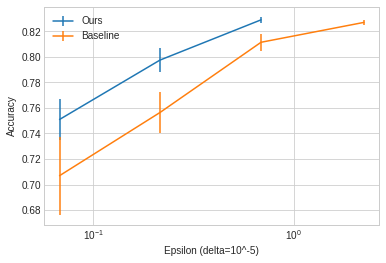

In [134]:
plt.errorbar(our_epsilons, our_means, yerr=our_stds, label='Ours')
plt.errorbar(baseline_epsilons, baseline_means, yerr=baseline_stds, label='Baseline')
plt.xscale('log')
plt.xlabel('Epsilon (delta=10^-5)')
plt.ylabel('Accuracy')
plt.legend()

In [570]:
[(eps, acc) for eps, acc in zip(baseline_epsilons, baseline_means)]

[(2.2459660262893473, 0.8268686421937197),
 (0.6886140424415113, 0.8101282618310481),
 (0.21559660262893474, 0.7718819106590005),
 (0.06796140424415112, 0.69640645731977)]

# Laplace Log Normal

In [45]:
def one_lln(sigma):
    x = np.random.laplace()
    y = np.random.normal()
    return x * np.exp(sigma * y)

In [46]:
def lln(size):
    sigma = 1
    x = np.random.laplace(size=size)
    y = np.random.normal(size=size)
    return x * np.exp(sigma * y)

In [47]:
np.mean(lln(500000))

-0.0045931651363306574